In [1]:
import sys
import os
modules_path = os.getcwd() + '/src/python'
sys.path.insert(0, modules_path)

# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from notebooks.utils import compute_user_penalty, get_team_values_df
from common.load import load_competition_data, process_team_logs

# Import common data

In [2]:
config = 'src/python/config_vbs2023.yaml'

# load competition data from dres files and auxiliary data (FPSs, sequences)
comp_data = load_competition_data(config)

# compute team logs and put them in the form of dataframes (or load them if already existing)
logs = process_team_logs(config, comp_data, force=False)

teams = comp_data['config']['teams']

# FIXME: badly patch the name of HTW into vibro
teams_adj = teams.copy()
teams_adj = [t if t != 'HTW' else 'vibro' for t in teams_adj]

teams.remove('VideoCLIP')

/disks/workspace/Workspace/VBS-Analysis/VBS23-Post-Hoc-Analysis/src/python/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/disks/workspace/Workspace/VBS-Analysis/VBS23-Post-Hoc-Analysis/src/python/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/disks/workspace/Workspace/VBS-Analysis/VBS23-Post-Hoc-Analysis/src/python/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/disks/workspace/Workspace/VBS-Analysis/VBS23-Post-Hoc-Analysis/src/python/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

# Analysis

## Best shot rank

In [38]:
def compute_data_for_best_shot_rank(
    data,
    teams,
    logs,
    split_user=False,
    max_records=10000,
    aggregate_users_for=[]):
    """
    Returns the view of the data interesting for the best_shot rank analysis, in the form of a Pandas dataframe
    """
    # self.max_records = max_records
    # self.best_user_policy = best_user_policy
    # self.where_missing_data_is = max_records * 2

    dfs = []
    for team in teams:
        team_df = logs[team].get_events_dataframe().reset_index()
        if team in aggregate_users_for:
        # these teams have undistinguishable physical users, given that their logs are taken from DRES
            team_df['user'] = 0
        team_df = get_team_values_df(data, team_df, split_user, max_records)
        dfs.append(team_df)

    total_df = pd.concat(dfs, axis=0).reset_index()

    view = total_df[total_df["rank_shot_margin_0"] != -1].groupby(['team', 'user']).agg('count')['rank_shot_margin_0']
    print(view)

    user_penalty = compute_user_penalty(total_df, max_records)
                
    total_df['user_penalty'] = user_penalty
    total_df['best_user'] = 1
    total_df.loc[total_df.groupby(['team', 'task'])['user_penalty'].idxmin(), 'best_user'] = 0
    total_df = total_df.drop(['user_penalty'], axis=1)

    return total_df

def build_best_rank_boxplot(
    df, 
    figsize=[7, 6], 
    show_boxplot=True, 
    swarmplot=True, 
    exclude_teams=[], 
    best_user_policy=True,
    where_missing_data_is=20000,
    max_records=1000,
    fill_missing=False,
    dataset='v3c',
    legend_loc="lower right",
    remove_legend=False):
    """
    Render the dataframe into a table or into a nice graph
    """

    if dataset == 'v3c':
        df = df[~df['task'].str.contains('m')]
    elif dataset == 'v3c-t':
        df = df[~df['task'].str.contains('m') & df['task'].str.contains('-t')]
    elif dataset == 'v3c-v':
        df = df[~df['task'].str.contains('m') & df['task'].str.contains('-v')]
    elif dataset == 'mvk':
        df = df[df['task'].str.contains('m')]
    elif dataset != 'v3c+mvk':
        raise ValueError(f'dataset argument {dataset} not recognized')

    # if fill_missing, missing datapoints are set in some random lines after max_records + k
    if fill_missing:
        # choices = [self.where_missing_data_is, self.where_missing_data_is * 10**(0.1)] #, self.where_missing_data_is * 10**(0.2)]
        df.sort_values(by=['rank_shot_margin_0'])
        df.loc[df['rank_shot_margin_0'] == -1, 'rank_shot_margin_0'] = np.random.uniform(
            where_missing_data_is * 10**(-0.15), 
            where_missing_data_is * 10**(0.15),
            len(df.loc[df['rank_shot_margin_0'] == -1]))
        # total_df["rank_shot_margin_0"] = total_df["rank_shot_margin_0"].loc.replace({-1: max_records + 10000})

    # select only r_s
    df = df[["rank_shot_margin_0", "team", "user", "best_user", "task"]]

    # filter out unwanted teams
    df = df[~df["team"].isin(exclude_teams)]

    # discard NaN values
    df = df[df["rank_shot_margin_0"] != -1]

    # rename users column for better visualization
    df['user'] = df['user'].replace({0: '1st', 1: '2nd'})

    # df = df.pivot(columns="team", values="r_s")
    # print(df)

    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=figsize)
    ax.set_yscale("log")
    r = list(range(0, int(math.log10(max_records))))
    r = r + [r[-1] + 1]
    ax.set_yticks([10**x for x in r] + [where_missing_data_is])
    ax.set_yticklabels(['1' if x==0 else '10' if x==1 else f'10$^{x}$' for x in r] + [f'N.A.']) # [f'>10$^{r[-1]}$'])

    ax.axhline(y=where_missing_data_is, linewidth=17, color='r', alpha=0.2)

    # Plot the orbital period with horizontal boxes
    if show_boxplot:
        sns.boxplot(x="team", hue="best_user" if best_user_policy else "user", y="rank_shot_margin_0", data=df,
                    whis=[0, 100], width=.6, palette="vlag")

    # Add in points to show each observation

    if swarmplot:
        sns.swarmplot(x="team", hue="best_user" if best_user_policy else "user", y="rank_shot_margin_0", data=df,
                    size=4, linewidth=.3, dodge=True, alpha=0.4 if show_boxplot else 1.0)
    else:
        sns.stripplot(x="team", hue="best_user" if best_user_policy else "user", y="rank_shot_margin_0", data=df,
                    size=5, linewidth=1, dodge=True, alpha=0.4 if show_boxplot else 1.0)
    
    handles, labels = ax.get_legend_handles_labels()
    if best_user_policy:
        labels[0] = "best"
        labels[1] = "other"
        
    if remove_legend:
        ax.legend_.remove()
    else:
        ax.legend(handles[:2], labels[:2], title="user", loc=legend_loc) # , ncol=2,)

    # Tweak the visual presentation
    ax.yaxis.grid(True)
    ax.set(ylabel="best shot rank")

team        user
CVHunter    0       19
            1       18
HTW         0       18
            1       18
VIREO       0        6
            1       14
VISIONE     0       19
            1       18
Verge       0       12
vitrivr     0       17
            1       16
vitrivr-VR  0       10
            1        8
Name: rank_shot_margin_0, dtype: int64


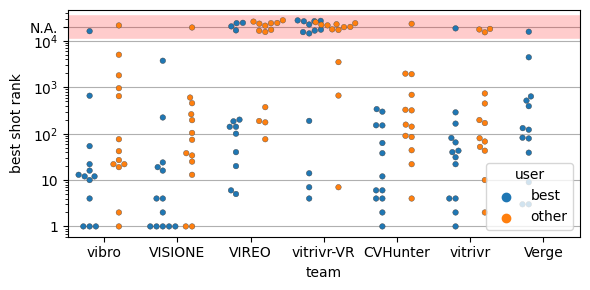

In [23]:
# best user policy, V3C

max_records = 10000
df_boxplot = compute_data_for_best_shot_rank(comp_data, teams, logs, max_records=max_records, split_user=True)
df_boxplot.loc[df_boxplot['team'] == 'HTW', 'team'] = 'vibro'
build_best_rank_boxplot(df_boxplot, show_boxplot=False, figsize=[6, 3], fill_missing=True, best_user_policy=True, where_missing_data_is=max_records*2, max_records=max_records, dataset='v3c')
plt.tight_layout()
plt.savefig('plots/kis_best_rank_boxplot_bestuser_v3c.pdf')
plt.show()

team        user
CVHunter    0       18
            1       17
HTW         0       18
            1       16
VIREO       0        6
            1       14
VISIONE     0       16
            1       18
vitrivr     0       16
            1       14
vitrivr-VR  0        9
            1        4
Name: rank_shot_margin_0, dtype: int64


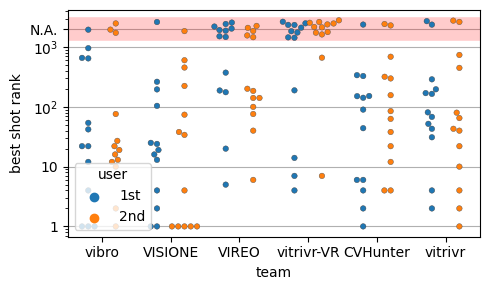

In [24]:
# real user policy, V3C

max_records = 1000
teams_filtered = list(teams)
teams_filtered.remove('Verge')
df_boxplot = compute_data_for_best_shot_rank(comp_data, teams_filtered, logs, max_records=max_records, split_user=True)
df_boxplot.loc[df_boxplot['team'] == 'HTW', 'team'] = 'vibro'
build_best_rank_boxplot(df_boxplot, show_boxplot=False, figsize=[5, 3], fill_missing=True, best_user_policy=False, where_missing_data_is=max_records*2, max_records=max_records, dataset='v3c', legend_loc='lower left')
plt.tight_layout()
plt.savefig('plots/kis_best_rank_boxplot_realuser_v3c.pdf')
plt.show()

team        user
CVHunter    0       18
            1       17
HTW         0       18
            1       16
VIREO       0        6
            1       14
VISIONE     0       16
            1       18
vitrivr     0       16
            1       14
vitrivr-VR  0        9
            1        4
Name: rank_shot_margin_0, dtype: int64


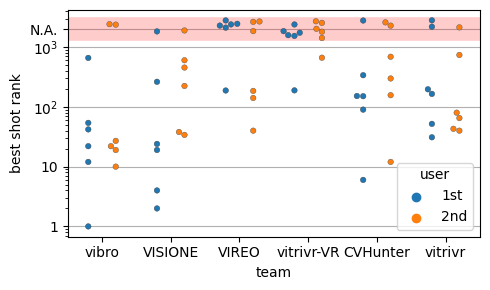

In [25]:
# real user policy on V3C, only visual
build_best_rank_boxplot(df_boxplot, show_boxplot=False, figsize=[5, 3], fill_missing=True, best_user_policy=False, where_missing_data_is=max_records*2, max_records=max_records, dataset='v3c-v', legend_loc='lower right')
plt.tight_layout()
plt.savefig('plots/kis_best_rank_boxplot_realuser_v3c_v.pdf')
plt.show()

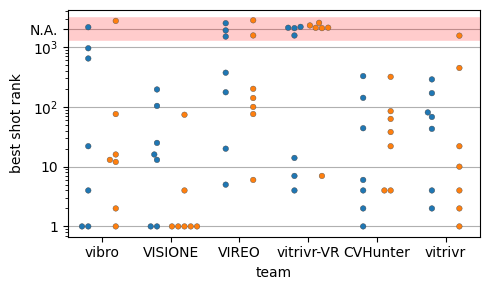

In [41]:
# real user policy on V3C, only textual

build_best_rank_boxplot(df_boxplot, show_boxplot=False, figsize=[5, 3], fill_missing=True, best_user_policy=False, where_missing_data_is=max_records*2, max_records=max_records, dataset='v3c-t', legend_loc='lower left',  exclude_teams=["Verge"], remove_legend=True)
plt.tight_layout()
plt.savefig('plots/kis_best_rank_boxplot_realuser_v3c_t.pdf')
plt.show()

team        user
CVHunter    0       19
            1       18
HTW         0       18
            1       18
VIREO       0        6
            1       14
VISIONE     0       19
            1       18
Verge       0       12
vitrivr     0       17
            1       16
vitrivr-VR  0       10
            1        8
Name: rank_shot_margin_0, dtype: int64


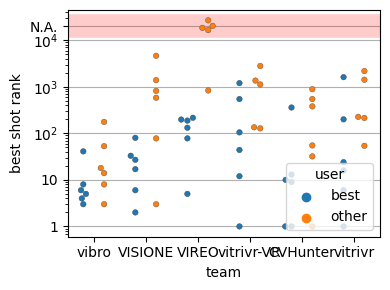

In [28]:
# best user policy on MVK

build_best_rank_boxplot(df_boxplot, show_boxplot=False, figsize=[4, 3], fill_missing=True, best_user_policy=True, where_missing_data_is=max_records*2, max_records=max_records, dataset='mvk', exclude_teams=["Verge"])
plt.tight_layout()
plt.savefig('plots/kis_best_rank_boxplot_bestuser_mvk.pdf')
plt.show()

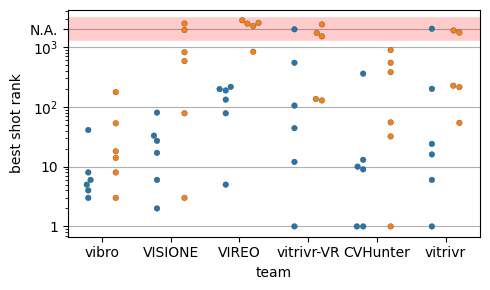

In [40]:
# real user policy on MVK

build_best_rank_boxplot(df_boxplot, show_boxplot=False, figsize=[5, 3], fill_missing=True, best_user_policy=True, where_missing_data_is=max_records*2, max_records=max_records, dataset='mvk', exclude_teams=["Verge"], remove_legend=True)
plt.tight_layout()
plt.savefig('plots/kis_best_rank_boxplot_realuser_mvk.pdf')
plt.show()

## Browsing efficiency scatterplot

In [31]:
def compute_data_for_browsing_efficiency_scatterplot(data, teams, logs, split_user=True, max_records=1000):
    """
    Returns the view of the data interesting for the current analysis, in the form of a Pandas dataframe
    """

    dfs = []
    for team in teams:
        team_df = logs[team].get_events_dataframe().reset_index()
        df = get_team_values_df(data, team_df, split_user, max_records)
        dfs.append(df)

    total_df = pd.concat(dfs, axis=0).reset_index()

    user_penalty = compute_user_penalty(total_df, max_records)       
    total_df['user_penalty'] = user_penalty
    total_df['best_user'] = 1
    total_df.loc[total_df.groupby(['team', 'task'])['user_penalty'].idxmin(), 'best_user'] = 0
    total_df = total_df.drop(['user_penalty'], axis=1)
    total_df = total_df[total_df["best_user"] == 0] # take only the best user directly

    return total_df

def build_browsing_efficiency_scatterplot(
    df, 
    time_of='first_appearance', 
    marker_size=5, 
    max_records=1000, 
    figsize=[7, 6], 
    include_incorrect_submissions=False, 
    split_tasks=False, 
    regression_line=False,
    remove_legend=False):
    """
    Render the dataframe into a table or into a nice graph
    """
    
    if not include_incorrect_submissions:
        df = df[df["time_correct_submission"] != -1]
    
    # remap time correct_submission
    df["correct_submission"] = (df["time_correct_submission"] >= 0)

    # discard NaN values
    df = df[(df["rank_shot_last_appearance"] != -1) & (df["rank_shot_first_appearance"] != -1)]

    df["elapsed_first_appearance"] = df["time_correct_submission"] - df["time_first_appearance"]
    df["elapsed_last_appearance"] = df["time_correct_submission"] - df["time_last_appearance"]
    first_appearance_df = df[["elapsed_first_appearance", "rank_shot_first_appearance", "team", "task", "correct_submission"]].rename(columns={"elapsed_first_appearance": "elapsed", "rank_shot_first_appearance": "rank_shot"})
    last_appearance_df = df[["elapsed_last_appearance", "rank_shot_last_appearance", "team", "task", "correct_submission"]].rename(columns={"elapsed_last_appearance": "elapsed", "rank_shot_last_appearance": "rank_shot"})
    df = pd.concat([first_appearance_df.assign(dataset='first_appearance'), last_appearance_df.assign(dataset='last_appearance')])

    df["task"] = df["task"].apply(lambda x: 'Textual-KIS' if 'kis-t' in x else ('Visual-KIS-M' if 'm' in x else 'Visual-KIS'))

    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=figsize)
    # ax.set_yscale("log")

    if include_incorrect_submissions:
        df.loc[~df["correct_submission"], "elapsed"] = 450

    df = df[df['dataset'] == time_of]

    if split_tasks == "visual":
        df = df[df['task'] == 'Visual-KIS']
    elif split_tasks == "textual":
        df = df[df['task'] == 'Textual-KIS']
    elif split_tasks == "marine":
        df = df[df['task'] == 'Visual-KIS-M']

    print(f"total rows: {len(df)}")

    ax.grid(True)

    # Plot elapsed (time delta) vs rank of first occurrence
    sns.scatterplot(data=df, x="rank_shot", y="elapsed", style="team", hue="task" if split_tasks=="same_graph" else "team", s=marker_size)
    # sns.scatterplot(data=df, x="rank_shot_last_appearance", y="elapsed_last_appearance")

    if regression_line:
        df_regression = df.copy()
        df_regression[~df_regression["correct_submission"]] = np.nan
        sns.regplot(x='rank_shot', y='elapsed', logx=True, scatter_kws={'s':0}, data=df_regression)
        # df_rolling = df_rolling.sort_values(by=["rank_shot"])
        # df_rolling['rolling_elapsed'] = df_rolling['elapsed'].rolling(25, min_periods=2).mean()
        # sns.lineplot(data=df_rolling, x="rank_shot", y="rolling_elapsed")

    if include_incorrect_submissions:
        rang = list(range(0, 500, 100)) + [450]
        ax.set_yticks(rang)
        ax.set_yticklabels(list(map(str,rang[:-1])) + ["NCS"])
        ax.axhline(450, ls='--', alpha=0.3)
        ax.set_ylim(0, 470)

    if remove_legend:
        ax.legend_.remove()
    else:
        ax.legend(loc='upper left')

    # Tweak the visual presentation
    ax.set(ylabel="time delta (seconds)", xlabel="shot rank")
    # sns.despine(trim=True, left=True)

    ax.set_xscale('log')
    r = list(range(0, int(math.log10(max_records))))
    r = r + [r[-1] + 1]
    ax.set_xticks([10**x for x in r])
    ax.set_xticklabels(['1' if x==0 else '10' if x==1 else f'10$^{x}$' for x in r])


/tmp/ipykernel_176789/127854574.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_first_appearance"] = df["time_correct_submission"] - df["time_first_appearance"]
/tmp/ipykernel_176789/127854574.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_last_appearance"] = df["time_correct_submission"] - df["time_last_appearance"]


total rows: 31


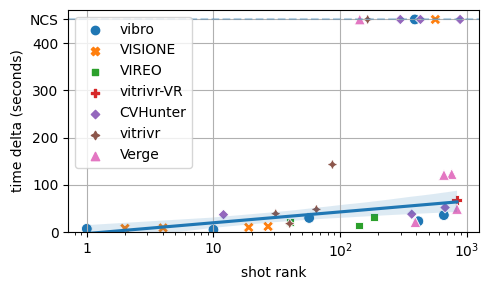

In [33]:
max_records = 1000
df_scatterplot = compute_data_for_browsing_efficiency_scatterplot(comp_data, teams, logs, max_records=max_records, split_user=True)
df_scatterplot.loc[df_scatterplot['team'] == 'HTW', 'team'] = 'vibro'
build_browsing_efficiency_scatterplot(df_scatterplot, time_of='first_appearance', figsize=[5, 3], marker_size=60, include_incorrect_submissions=True, split_tasks="visual", regression_line=True, max_records=max_records)
plt.tight_layout()
plt.savefig('plots/kis_browsing_efficiency_scatterplot_V3C_visual.pdf')
plt.show()

/tmp/ipykernel_176789/127854574.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_first_appearance"] = df["time_correct_submission"] - df["time_first_appearance"]
/tmp/ipykernel_176789/127854574.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_last_appearance"] = df["time_correct_submission"] - df["time_last_appearance"]


total rows: 42


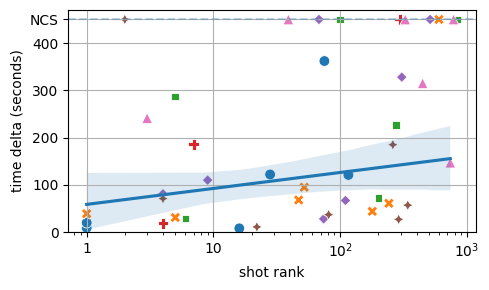

In [35]:
build_browsing_efficiency_scatterplot(df_scatterplot, time_of='first_appearance', figsize=[5, 3], marker_size=60, include_incorrect_submissions=True, split_tasks="textual", regression_line=True, max_records=max_records, remove_legend=True)
plt.tight_layout()
plt.savefig('plots/kis_browsing_efficiency_scatterplot_V3C_textual.pdf')
plt.show()

/tmp/ipykernel_176789/127854574.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_first_appearance"] = df["time_correct_submission"] - df["time_first_appearance"]
/tmp/ipykernel_176789/127854574.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_last_appearance"] = df["time_correct_submission"] - df["time_last_appearance"]


total rows: 34


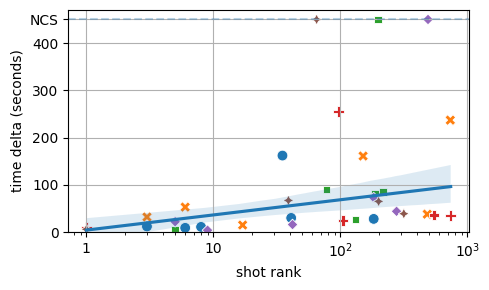

In [36]:
build_browsing_efficiency_scatterplot(df_scatterplot, time_of='first_appearance', figsize=[5, 3], marker_size=60, include_incorrect_submissions=True, split_tasks="marine", regression_line=True, max_records=max_records, remove_legend=True)
plt.tight_layout()
plt.savefig('plots/kis_browsing_efficiency_scatterplot_MVK.pdf')
plt.show()

## Browsing storyline

In [35]:
def compute_data_for_browsing_storyline(data, teams, logs, best_user=True):
    """
    Returns the view of the data interesting for the current analysis, in the form of a Pandas dataframe
    """

    dfs = []
    for team in teams:
        df = logs[team].get_events_dataframe().reset_index()
        # df = get_team_values_df(data, team_df, split_user, max_records)
        dfs.append(df)

    total_df = pd.concat(dfs, axis=0).reset_index()

    if best_user:
        df_penalty = total_df.copy()
        # we do not care about the time
        df_penalty['time_best_video'] = 0
        df_penalty['time_best_shot'] = 0
        user_penalty = compute_user_penalty(df_penalty, max_records=10000)
        total_df['user_penalty'] = user_penalty
        # for each "task", "team", there are rows with different "user", which can be 0 or 1. For each group, return the user id (0 or 1) which achieves the lowest rank
        best_users = total_df.loc[total_df.groupby(["task", "team"])["user_penalty"].idxmin(), ["task", "team", "user"]].rename(columns={"user": "best_user"})
        # now, for each "task", "team" group, keep the rows where the "user" is the best user in the corresponding best_user dataframe
        total_df = total_df.merge(best_users, on=["task", "team"], how="left")
        total_df = total_df[total_df['user'] == total_df['best_user']]

    return total_df

def build_browsing_storyline_plot(data, figsize=[5, 3], user=0, teams=[], task="vbs23-kis-v1", rank_column="rank_shot_margin_0", task_end_time=420, show_title=False, show_legend=True):
    data = data[["elapsed_since_task_start_ms", "team", "task", "user", rank_column, "correct_submission_time_ms"]]
    #data = data.rename(columns={"rank_shot_margin_0": "frame", "rank_video": "video"})
    data = data.replace(np.inf, np.nan)
    data = data[data['team'].isin(teams) & (data['task'] == task)]
    data = data.rename(columns={rank_column: "rank"})
    #data = data.melt(id_vars=["elapsed_since_task_start_ms", "team", "task", "user", "correct_submission_time_ms"], var_name="rank_type", value_name="rank")

    # substitute nans in the column correct_submission_time_ms with task_end_time * 1000
    data['correct_submission_time_ms'] = data['correct_submission_time_ms'].fillna(task_end_time * 1000)

    data = data.melt(id_vars=["team", "task", "user", "rank"], var_name="elapsed_since", value_name="elapsed_ms")
    data = data.sort_values(by=["task", "team", "elapsed_ms"])
    data.drop_duplicates(subset=["task", "team", "user", "elapsed_since", "elapsed_ms"], inplace=True)
    # remove rows where column "rank" is nan, but only if column "elapsed_since" is not "correct_submission_time_ms"
    data = data[~(data['rank'].isna()) | (data['elapsed_since'] == "correct_submission_time_ms")]

    # put to nan the values in column "rank" where column "elapsed_since" is "correct_submission_time_ms"
    data.loc[data['elapsed_since'] == "correct_submission_time_ms", 'rank'] = np.nan

    # interpolate nan values in column "rank" by repeating the last one
    data['rank'] = data['rank'].fillna(method='ffill')
    data['elapsed_ms'] = data['elapsed_ms'] / 1000

    f, ax = plt.subplots(figsize=figsize)

    teams = data['team'].unique()
    pal = dict(zip(teams, sns.color_palette("Set1", n_colors=len(teams))))

    ax.set_yscale("log")
    ax.set_ylabel('shot rank' if rank_column == "rank_shot_margin_0" else 'video rank')
    ax.set_xlabel('task time (s)')
    ax.set_xlim(0, task_end_time + 5)
    if show_title:
        ax.set_title(task)
    ax.grid(True)
    sns.lineplot(data=data, x="elapsed_ms", y="rank", hue="team", style="team", drawstyle="steps-post", markers=True, palette=pal, marker='o', markersize=4)

    # draw the correct submission point
    data_submission_ok = data[(data['elapsed_since'] == "correct_submission_time_ms") & (data['elapsed_ms'] < task_end_time)]
    sns.scatterplot(data=data_submission_ok, x="elapsed_ms", y="rank", hue="team", markers=True, marker='H', s=100, legend=False, palette=pal, zorder=10)

    # draw the correct submission point
    data_submission_wrong = data[(data['elapsed_since'] == "correct_submission_time_ms") & (data['elapsed_ms'] == task_end_time)]
    sns.scatterplot(data=data_submission_wrong, x="elapsed_ms", y="rank", hue="team", markers=True, marker='X', s=100, legend=False, palette=pal, zorder=10)

    # draw legend outside of plot
    if show_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        ax.get_legend().remove()

    

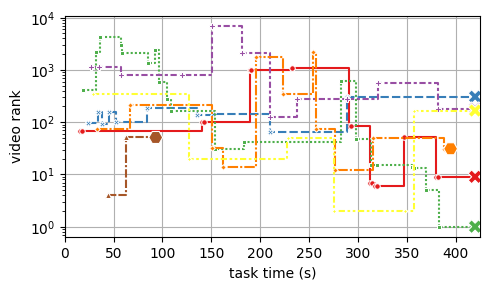

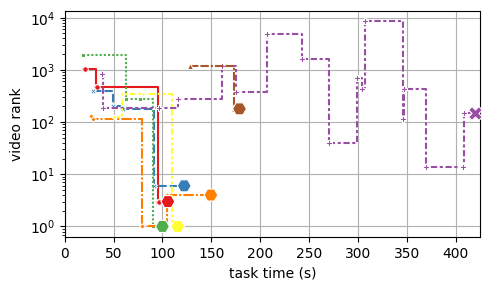

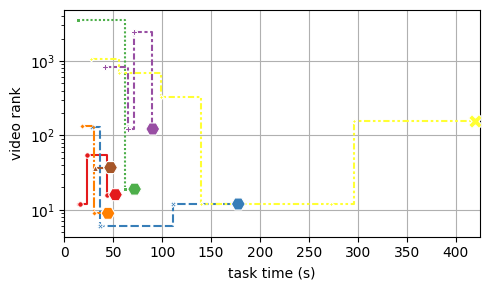

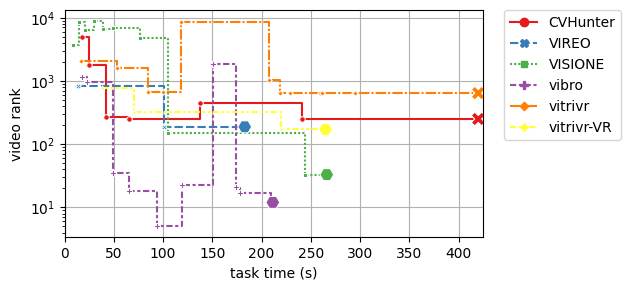

In [55]:
df_storyline = compute_data_for_browsing_storyline(comp_data, teams, logs, best_user=True)
df_storyline.loc[df_storyline['team'] == 'HTW', 'team'] = 'vibro'
# df_storyline = df_storyline[df_storyline['team'] != 'Verge']
tasks = ['vbs23-kis-t3', 'vbs23-kis-t5', 'vbs23-kis-v5', 'vbs23-kis-v-m4']
# tasks = df_storyline['task'].unique()
for i, t in enumerate(tasks):
    df_storyline_copy = df_storyline.copy()
    x_size = 6.45 if i == len(tasks) - 1 else 5
    show_legend = True if i == len(tasks) - 1 else False
    build_browsing_storyline_plot(df_storyline_copy, figsize=[x_size, 3], teams=teams_adj, task=t, rank_column="rank_video", show_title=False, show_legend=show_legend)
    plt.tight_layout()
    plt.savefig(f'plots/kis_browsing_storyline_{t}.pdf')
    plt.show()